This code imports the necessary libraries (pandas, numpy, matplotlib, and Path from the pathlib module) to handle data analysis and plotting. It then searches for the accelerometer data file 0_z.csv in two possible locations and selects the one that exists. The CSV file is read into a pandas DataFrame, ignoring any lines starting with # (used for comments). 

- The column names are cleaned by stripping spaces and converting them to lowercase. The main data columns (t, x, y, and z) are converted to numeric values, forcing any invalid entries to become missing values (NaN). 
- Next, any rows containing missing data are removed, and the dataset is sorted by the time column (t) before resetting the index to keep it tidy. 

- Finally, the code displays the first few rows of the cleaned dataset to confirm that the data has been properly loaded and prepared for further analysis.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

csv_candidates = [Path('0_z.csv'), Path('/mnt/data/0_z.csv')]
for p in csv_candidates:
    if p.exists():
        csv_path = p
        break

df = pd.read_csv(csv_path, comment='#')
df.columns = [c.strip().lower() for c in df.columns]
for c in ['t','x','y','z']:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=['t','x','y','z']).sort_values('t').reset_index(drop=True)
df.head()

,t,x,y,z
0,0.00,-0.0938,-0.0156,0.9531
1,0.02,-0.0938,-0.0156,0.9531
2,0.04,-0.0938,-0.0156,0.9531
3,0.06,-0.0938,-0.0156,0.9531
4,0.08,-0.0938,-0.0156,0.9531


This part of the code defines and applies a function to compute ENMO (Euclidean Norm Minus One), a common measure of physical activity intensity from accelerometer data.
The function compute_enmo(x, y, z) below, calculates the magnitude of the acceleration vector at each time point using the formula

$$
\text{ENMO} = \max \left(0,\ \sqrt{x^2 + y^2 + z^2} - 1 \right)
$$

where *x*, *y*, and *z* are the acceleration components (in g).

and then applies np.maximum(0, …) to set any negative values to zero, since ENMO cannot be negative.
The result represents the movement intensity (in g) after removing the static 1 g effect of gravity.
The computed ENMO values are added to the DataFrame as a new column called enmo_g, and the last line displays the first few rows to verify the calculation

In [2]:
def compute_enmo(x, y, z):
    return np.maximum(0.0, np.sqrt(x*x + y*y + z*z) - 1.0)
df['enmo_g'] = compute_enmo(df['x'].values, df['y'].values, df['z'].values)
df[['t','x','y','z','enmo_g']].head()

,t,x,y,z,enmo_g
0,0.00,-0.0938,-0.0156,0.9531,0.0
1,0.02,-0.0938,-0.0156,0.9531,0.0
2,0.04,-0.0938,-0.0156,0.9531,0.0
3,0.06,-0.0938,-0.0156,0.9531,0.0
4,0.08,-0.0938,-0.0156,0.9531,0.0


This function integrates ENMO values over time to quantify the total movement intensity during a given period.
It takes two inputs — enmo, the array of ENMO values (in g), and t_seconds, the corresponding time points (in seconds).
Because the integration needs to produce a result in g·minutes, the time values are first converted from seconds to minutes by dividing by 60.
Then, the function uses NumPy’s trapezoidal integration method (np.trapz) to calculate the area under the ENMO curve, which represents the accumulated intensity of movement over that time segment.
The result, returned as a float, expresses the total activity during the segment in g·min (ENMO multiplied by duration in minutes).

In [3]:
def integrate_segment(enmo, t_seconds):
    t_min = t_seconds / 60.0   # <-- convert to minutes
    return float(np.trapz(enmo, t_min))  # result in g·min

This function splits the ENMO data into fixed time intervals (epochs) of a chosen length in seconds.
For each epoch, it selects the corresponding ENMO values, integrates them using the integrate_segment() function, and stores the result in g·min.
The output is a DataFrame listing each epoch’s start time, midpoint (in minutes), and total integrated ENMO, which summarizes movement intensity over time.

In [4]:
def enmo_epochs(df, epoch_s):
    t0, t1 = df['t'].iloc[0], df['t'].iloc[-1]
    edges = np.arange(t0, t1 + epoch_s, epoch_s)
    rows = []
    for i in range(len(edges)-1):
        a, b = edges[i], edges[i+1]
        seg = df[(df['t'] >= a) & (df['t'] <= b)]
        val = integrate_segment(seg['enmo_g'].values, seg['t'].values) if len(seg) >= 2 else 0.0
        rows.append({'epoch_start_s': a, 'epoch_mid_min': (a+b)/2.0/60.0, 'integrated_enmo_gmin': val})
    return pd.DataFrame(rows)

This part of the code computes the integrated ENMO for different epoch lengths — 10 s, 30 s, and 60 s — and prints the number of epochs created for each.

- It then generates a line plot of ENMO (g) over time (in minutes) to visualize changes in movement intensity throughout the recording.

- The plot provides a clear view of when activity peaks occur.

In [5]:
epochs = {10: enmo_epochs(df, 10), 30: enmo_epochs(df, 30), 60: enmo_epochs(df, 60)}
for k,v in epochs.items():
    print(k, 's ->', len(v), 'époques')

10 s -> 42 époques
30 s -> 14 époques
60 s -> 7 époques


C:\Users\omarf\AppData\Local\Temp\ipykernel_26428\858806833.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(enmo, t_min))  # result in g·min


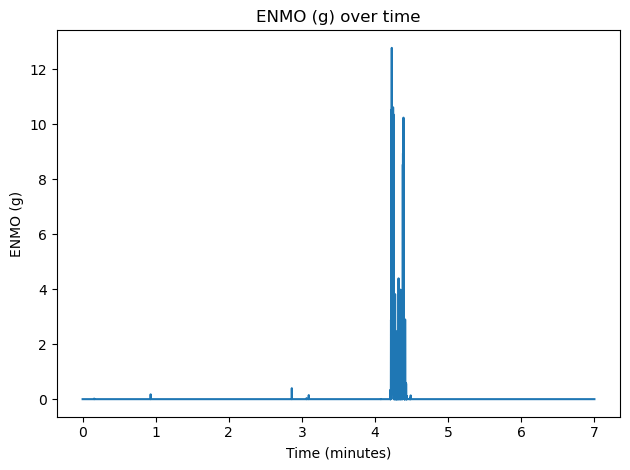

In [6]:
plt.figure()
plt.plot(df['t']/60.0, df['enmo_g'])
plt.xlabel('Time (minutes)')
plt.ylabel('ENMO (g)')
plt.title('ENMO (g) over time')
plt.tight_layout()
plt.show()